# A Deep Q-Learning approach for solving Mountain Car
**Presented by:**
- Mattia Aquilina, 1921153
- Luca Zanchetta, 1848878

## Problem Addressed

*Mountain Car* is a deterministic Markov Decision Process (MDP) that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of this MDP is to strategically accelerate the car to reach the goal state on top of the right hill.

Given an action, the mountain car follows the following transition dynamics:
$$
velocity_{t+1} = velocity_t + (action - 1) * force - cos(3 * position_t) * gravity\\

position_{t+1} = position_t + velocity_t+1
$$
where *force* = 0.001 and *gravity* = 0.0025.

The collisions at either end are inelastic with the velocity set to 0 upon collision with the wall. The position is clipped to the range [-1.2, 0.6] and velocity is clipped to the range [-0.07, 0.07].

### Action Space

The action space is discrete, and constituted by 3 deterministic actions:

- **0**: The car accelerates to the *left*;
- **1**: The car does not accelerate;
- **2**: The car accelerates to the *right*.

### Observation space

The observation space is a *ndarray* with shape (2,), that stores the following information:

|    Num      | Observation |     Min     |     Max     |
| ----------- | ----------- | ----------- | ----------- |
| 0           | x-Position  |     -1.2    |     0.6     | 
| 1           | Velocity    |    -0.07    |     0.07    |

### Rewards

Each time the agent steps by performing an action, it receives -1 as reward; the goal of the agent is to maximize the overall reward obtained. The singularity of this environment is in the fact that after 200 steps, the single episode terminates; therefore, the goal of the agent is to maximize the overall reward within those 200 steps. 


## Solution Adopted

In order to solve this environment, we have relied on an approach consisting of combining the Q-Learning algorithm with deep neural networks, thus replacing the need for a table to store the Q-values; such an approach is commonly known as **Deep Q-Learning**. It is well known that Deep Q-Networks obey to the **Bellman Equation**:
$$
    \hat{Q}(s, a) = r + \gamma\underset{a'}{\operatorname{max}}\hat{Q}(s', a')
$$
where:
- *s* represents the current state of the environment;
- *a* represents the current selected action;
- *r* represents the reward obtained by performing the action *a* in the current state *s* of the environment;
- *s'* represents the next state of the environment, obtained after having performed the current selected action *a*;
- *a'* represents the next action, which will give rise to the future reward;
- *$\gamma$* represents the *discount factor*.

The main point of this approach is to have a neural network that, given as input the state of the environment, outputs the Q-values related to all the possible actions that can be performed.

Another important concept that comes into play is the concept of **Experience Replay**: it is an approach consisting of storing the experiences of the agent into a buffer, called *replay memory*, that will be used to generate the batch for training the network. In particular, the replay memory is a queue in which there are stored tuples of the form:

$$ (state, action, reward, next\_state) $$

The idea is that when such a buffer is full (or, when it contains *enough* tuples to feed a batch), a batch is created by randomly sampling the memory, for as many tuples as indicated by the pre-defined batch size. The batch size will be then used to create the dataset, that will be in turn used to train the neural network. Further details will be given later on, during the implementation phase.

Now, it is important to mention that we have tried to solve the *Mountain Car* environment with three different approaches, in order to compare their performance. Further details are given below.

### Implementation

#### Install and Import Dependencies

In [ ]:
!pip install gymnasium[classic-control]
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install keras

In [1]:
import gymnasium as gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from collections import deque

#### Hyperparameters

In [2]:
EXP_MAX_SIZE = 5000             # Maximum size of replay memory
BATCH_SIZE = EXP_MAX_SIZE // 10 # Batch size
EPISODES = 2000                 # Number of training episodes
TRAIN_EVERY = 20                # We train the neural network every 10 episodes
RAND_EPISODES = 400             # Exploration episodes

EPS_MAX = 85                    # Initial exploration probability
EPS_MIN = 5                     # Final exploration probability
GAMMA = .9                      # Discount factor

#### Environment Setup

In [3]:
env = gym.make("MountainCar-v0")
env.reset()

state_size = env.observation_space.shape[0]         # 2 states
action_size = env.action_space.n                    # 3 actions

experience = deque([],EXP_MAX_SIZE)                 # Past experience arranged as a queue

c_reward = 0                                        # Current cumulative reward
checkpoint_first =  './checkpoints_first/cp.ckpt'   # File to record network configuration in the first approach
checkpoint_second = './checkpoints_second/cp.ckpt'  # File to record network configuration in the second approach
checkpoint_third =  './checkpoints_third/cp.ckpt'   # File to record network configuration in the third approach


epsilon = EPS_MAX                                   # Initialization of the epsilon

#### Neural Network

In [4]:
def createModel():
    model = Sequential()
    model.add(Dense(256, input_shape=( state_size , ),activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(action_size,activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

In [5]:
# Model setup
model = createModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               768       
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 37,891
Trainable params: 37,891
Non-trainable params: 0
_________________________________________________________________


#### Plotting Utility

In [6]:
# Show the reward with respect to each episode
def showPlotReward(value):
    plt.plot(value)
    plt.xlabel('episode')
    plt.ylabel('total reward')

    plt.show()

#### First Approach

The first approach was the classical one: we have implemented a reinforcement learning agent originally based on Q-Learning, in which we have inserted an artificial neural network in order to replace the need for storing the Q-values in a Q-table. The neural network has been trained in order to give to the agent the best action to perform (i.e., the action that maximizes the reward), given the current state of the environment. 

However, we noticed that the network was hardly learning something at the end of the training process, and even increasing the number of training episodes did not help at all: the reinforcement learning agent was not able to solve the environment in the testing phase. We suspect that there are two possible reasons why:
- The agent may not have **enough time** within a single episode for learning how to behave in each particular situation. Indeed, the episode is normally truncated when it has reached a total episode reward of -200; therefore, we inferred that maybe increasing the number of steps per episode would have improved the performance of the network.
- The particular **reward mechanism** of the *Mountain Car* environment may not be perfectly suitable for allowing the neural network to learn by itself which is the best sequence of actions to perform in order to solve the environment. Indeed, as we mentioned before, each time the agent steps by performing an action, it receives -1 as reward, until it is able to solve the environment; it means that the neural network is not able to infer the correct sequence of actions to perform for allowing the agent to solve the environment, if the there is no reward for "correct" actions. 

That's why we have decided to try new approaches, and to compare the resulting performances, although we know that these approaches are not exactly what was required for the exam. The only purpose of these experiments was to understand the behavior of the learning process with respect to that of the environment, and to discover how to solve the issues that arosed during this approach.

##### Training

In [ ]:
# For plotting purposes
rewardList = []

for episode in range(1, EPISODES):
    state, _ = env.reset()
    total_reward = 0

    truncated = False
    done = False
    actionRecap = [0,0,0]   # For debugging purposes: we count the number of predicted actions in each episode 

    while not done and not truncated:
        # Default choice is random
        action = env.action_space.sample()
        
        # Choose between greedy and random policy
        if np.random.random()*100 >= epsilon and episode > RAND_EPISODES:
            # We used the model to predict the next action
            q_values = model.predict_on_batch(tf.constant([state]))
            action = np.argmax(q_values[0])
            actionRecap[action] += 1
        
        # Perform a step
        new_state, reward, done, truncated, info = env.step(action)        
        total_reward += reward

        # Popping memory policy
        if len(experience)>= EXP_MAX_SIZE:
            experience.popleft()

        # Fill the experience replay memory with the experience of the current episode
        experience.append([*[state, action, reward, new_state, done]])
        state = new_state
        
        
    if len(experience) >= BATCH_SIZE and episode % TRAIN_EVERY == 0:    # It's time to train!
        # Create a batch by randomly sampling the experience replay memory
        batch = random.sample(experience, BATCH_SIZE)
        datasetGen = []

        for i in range(0, len(batch)):
            # Single entry of the computed batch
            entry = batch[i]

            state = entry[0]        # Gather the current state
            action = entry[1]       # Gather the current action
            reward = entry[2]       # Gather the current reward
            new_state = entry[3]    # Gather the next state
            done = entry[4]         # Gather the information about whether the current state was a terminal state or not

            # By default, the q-values of the next state are the reward 
            # (this is true only if the current state is a terminal state)
            qValueNext = reward
            if not done:    # Not the terminal state
                qValueNext += GAMMA * np.max(model.predict_on_batch(tf.constant([new_state])))      # DQN Bellman equation
                
            qcurrent = model.predict_on_batch(tf.constant([state]))[0]
            qcurrent[action] = qValueNext
            datasetGen.append([*[*state, *qcurrent]])

        # Compute the dataset used for training
        dataset = np.array(datasetGen)
        X = dataset[:,:state_size]  # Observations
        Y = dataset[:,state_size:]  # Q-values of the actions
        
        # Train the model
        model.fit(tf.constant(X),tf.constant(Y), validation_split=0.2)
        
        # Linear epsilon decay
        if episode > RAND_EPISODES:
            epsilon = ((EPS_MIN - EPS_MAX) * (episode - RAND_EPISODES - 1 )) / (EPISODES*.80 - 1) + EPS_MAX
            if epsilon <= EPS_MIN:
                epsilon = EPS_MIN


    rewardList.append(total_reward)
    print("Episode: {}/{}, Total Reward: {}, Exploration Rate: {:.2f}, Actions: 0 - {}; 1 - {}; 2 - {}".format(
        episode, EPISODES, total_reward, epsilon, actionRecap[0],actionRecap[1],actionRecap[2]))

env.close()

Episode: 1/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 2/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 3/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 4/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 5/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 6/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 7/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 8/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 9/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 10/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 11/2000, Total Reward: -200.0, Exploration Rate: 85.00, Acti

In [ ]:
# Save weights
model.save_weights(checkpoint_first)

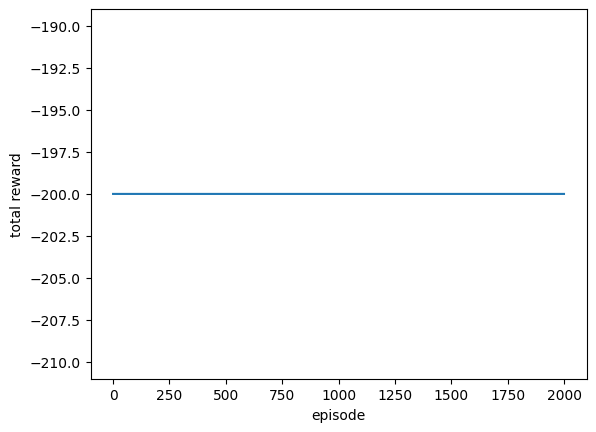

In [ ]:
# Plot the rewards wrt each training episode
showPlotReward(rewardList)

##### Testing

In [7]:
# Load the pre-trained model
model = createModel()
model.load_weights(checkpoint_first)

In [8]:
# Load the pre-trained model
model = createModel()
model.load_weights(checkpoint_first)

env = gym.make("MountainCar-v0", render_mode= "human")
state, _ = env.reset()
total_reward = 0
truncated = False
done = False
while not done and not truncated:
        q_values = model.predict(tf.constant([state]), verbose=0)
        action = np.argmax(q_values[0])
        new_state, reward, done, truncated, info = env.step(action)
       
        total_reward += reward
        state = new_state
        env.render()

print("Reward: {}".format(total_reward))
env.close()

Reward: -200.0


#### Second Approach

The second approach is based on the first one: again, we have implemented a reinforcement learning agent originally based on Q-Learning, in which we have inserted an artificial neural network in order to replace the need for storing the Q-values in a Q-table. The neural network has been trained in order to give to the agent the best action to perform (i.e., the action that maximizes the reward), given the current state of the environment. 

The only change that is worth mentioning is that we have slightly changed the number of steps per episode: we have increased such a number from 200 to 1000. In this approach, our aim was to allow the agent to have more time within each single episode, in order to have a better understanding of the environment. Our hope was to solve the issues encountered in the first approach, although we know that modifying a characteristic of the environment is not the best way for training a model to solve the original environment. In fact, as we can see from the plot below, the training process was too fluctuating: as a result, even in this case the agent was not able to solve the (original!) environment in the testing phase. 

That's why the only option left was the third approach: modifying the reward policy of the environment.

##### Training

In [7]:
# For plotting purposes
rewardList = []
max_steps_per_episode = 1000

for episode in range(1, EPISODES+1):
    state, _ = env.reset()
    total_reward = 0
    steps = 0

    truncated = False
    done = False
    actionRecap = [0,0,0]   # For debugging purposes: we count the number of predicted actions in each episode 

    while not done and steps < max_steps_per_episode:
        # Default choice is random
        action = env.action_space.sample()
        
        # Choose between greedy and random policy
        if np.random.random()*100 >= epsilon and episode > RAND_EPISODES:
            # We use the model to predict the next action
            q_values = model.predict_on_batch(tf.constant([state]))
            action = np.argmax(q_values[0])
            actionRecap[action] += 1

        # Perform a step
        new_state, reward, done, truncated, info = env.step(action)        
        total_reward += reward

        # Popping memory policy
        if len(experience)>= EXP_MAX_SIZE:
            experience.popleft()

        # Fill the experience replay memory with the experience of the current episode
        experience.append([*[state, action, reward, new_state, done]])
        state = new_state
        steps += 1
        
        
    if len(experience) >= BATCH_SIZE and episode % TRAIN_EVERY == 0:    # It's time to train!
        # Create a batch by randomly sampling the experience replay memory
        batch = random.sample(experience, BATCH_SIZE)
        datasetGen = []

        for i in range(0, len(batch)):
            # Single entry of the computed batch
            entry = batch[i]

            state = entry[0]        # Gather the current state
            action = entry[1]       # Gather the current action
            reward = entry[2]       # Gather the current reward
            new_state = entry[3]    # Gather the next state
            done = entry[4]         # Gather the information about whether the current state was a terminal state or not

            # By default, the q-values of the next state are the reward 
            # (this is true only if the current state is a terminal state)
            qValueNext = reward
            if not done:    # Not the terminal state
                qValueNext += GAMMA * np.max(model.predict_on_batch(tf.constant([new_state])))      # DQN Bellman equation              
                
            qcurrent = model.predict_on_batch(tf.constant([state]))[0]
            qcurrent[action] = qValueNext
            datasetGen.append([*[*state, *qcurrent]])

        # Compute the dataset used for training
        dataset = np.array(datasetGen)
        X = dataset[:,:state_size]  # Observations
        Y = dataset[:,state_size:]  # Q-values of the actions
        
        # Train the model
        model.fit(tf.constant(X),tf.constant(Y), validation_split=0.2)
        
        # Linear epsilon decay
        if episode > RAND_EPISODES:
            epsilon = ((EPS_MIN - EPS_MAX) * (episode - RAND_EPISODES - 1 )) / (EPISODES*.80 - 1) + EPS_MAX
            if epsilon <= EPS_MIN:
                epsilon = EPS_MIN


    rewardList.append(total_reward)
    print("Episode: {}/{}, Total Reward: {}, Exploration Rate: {:.2f}, Actions: 0 - {}; 1 - {}; 2 - {}".format(
        episode, EPISODES, total_reward, epsilon, actionRecap[0],actionRecap[1],actionRecap[2]))

env.close()

Episode: 1/2000, Total Reward: -1000.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 2/2000, Total Reward: -1000.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 3/2000, Total Reward: -1000.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 4/2000, Total Reward: -1000.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 5/2000, Total Reward: -1000.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 6/2000, Total Reward: -1000.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 7/2000, Total Reward: -1000.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 8/2000, Total Reward: -1000.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 9/2000, Total Reward: -1000.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 10/2000, Total Reward: -1000.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 11/2000, Total Reward: -1000.0, Exploration Rate: 

In [ ]:
# Save weights
model.save_weights(checkpoint_second)

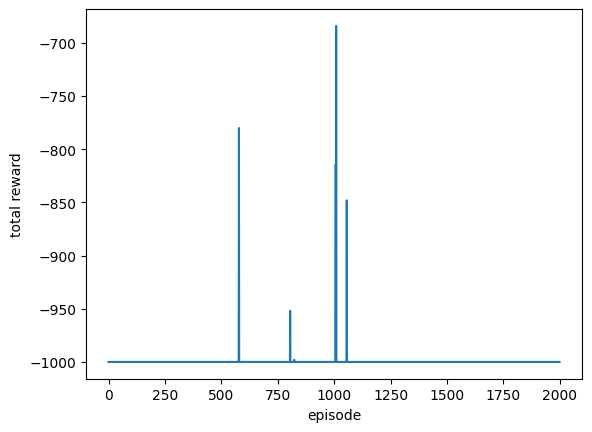

In [8]:
# Plot the rewards wrt each training episode
showPlotReward(rewardList)

##### Testing

In [9]:
# Load the pre-trained model
model = createModel()
model.load_weights(checkpoint_second)

In [10]:
env = gym.make("MountainCar-v0", render_mode= "human")
state, _ = env.reset()
total_reward = 0
truncated = False
done = False
while not done and not truncated:
        q_values = model.predict(tf.constant([state]), verbose=0)
        action = np.argmax(q_values[0])
        new_state, reward, done, truncated, info = env.step(action)
       
        total_reward += reward
        state = new_state
        env.render()

print("Reward: {}".format(total_reward))
env.close()

Reward: -200.0


#### Third Approach

The third approach is based on the first one too: again, we have implemented a reinforcement learning agent originally based on Q-Learning, in which we have inserted an artificial neural network in order to replace the need for storing the Q-values in a Q-table. The neural network has been trained in order to give to the agent the best action to perform (i.e., the action that maximizes the reward), given the current state of the environment. 

The only change that is worth mentioning is that we have slightly changed the reward policy: although we know that one should be careful in changing the reward policy of an environment, we noticed that this was a key point for improving the agent's performances. 

First, we have tried to define a reward policy based on both the velocity and the position of the car, but this approach ended up in having an agent that was continuously performing the same action, i.e. it was moving the car in the same direction. What worked for us was the policy based on **rewarding the agent whenever it chooses to invert the acceleration while climbing on the hill**.

In particular, if the agent is running on the right side of the hill and it decides to perform the action 2 (i.e., accelerate to the right), it will obtain a bonus of "+1" to the current reward; similarly, if the agent is running on the left side of the hill and it decides to perform the action 0 (i.e., accelerate to the left), it will obtain the same bonus of "+1" to the current reward. Although we know that this solution might not be the best one for solving the environment in the context of the Machine Learning exam, this was the best solution in terms of performance, because the agent was able to solve the environment in much less training episodes with respect to the other approaches.


##### Training

In [ ]:
# For plotting purposes
rewardList = []

for episode in range(1, EPISODES+1):
    state, _ = env.reset()
    total_reward = 0

    truncated = False
    done = False
    actionRecap = [0,0,0]   # For debugging purposes: we count the number of predicted actions in each episode 

    while not done and not truncated:
        # Default choice is random
        action = env.action_space.sample()
        
        # Choose between greedy and random policy
        if np.random.random()*100 >= epsilon and episode > RAND_EPISODES:
            # We use the model to predict the next action
            q_values = model.predict_on_batch(tf.constant([state]))
            action = np.argmax(q_values[0])
            actionRecap[action] += 1

        # Perform a step
        new_state, reward, done, truncated, info = env.step(action)        
        total_reward += reward

        # Reward policy
        if new_state[0] - state[0] > 0 and action == 2: 
            reward = reward + 1
        if new_state[0] - state[0] < 0 and action == 0: 
            reward = reward + 1
        else:
            reward = reward

        # Popping memory policy
        if len(experience)>= EXP_MAX_SIZE:
            experience.popleft()

        # Fill the experience replay memory with the experience of the current episode
        experience.append([*[state, action, reward, new_state, done]])
        state = new_state
        
        
    if len(experience) >= BATCH_SIZE and episode % TRAIN_EVERY == 0:    # It's time to train!
        # Create a batch by randomly sampling the experience replay memory
        batch = random.sample(experience, BATCH_SIZE)
        datasetGen = []

        for i in range(0, len(batch)):
            # Single entry of the computed batch
            entry = batch[i]

            state = entry[0]        # Gather the current state
            action = entry[1]       # Gather the current action
            reward = entry[2]       # Gather the current reward
            new_state = entry[3]    # Gather the next state
            done = entry[4]         # Gather the information about whether the current state was a terminal state or not

            # By default, the q-values of the next state are the reward 
            # (this is true only if the current state is a terminal state)
            qValueNext = reward
            if not done:    # Not the terminal state
                qValueNext += GAMMA * np.max(model.predict_on_batch(tf.constant([new_state])))      # DQN Bellman equation              
                
            qcurrent = model.predict_on_batch(tf.constant([state]))[0]
            qcurrent[action] = qValueNext
            datasetGen.append([*[*state, *qcurrent]])

        # Compute the dataset used for training
        dataset = np.array(datasetGen)
        X = dataset[:,:state_size]  # Observations
        Y = dataset[:,state_size:]  # Q-values of the actions
        
        # Train the model
        model.fit(tf.constant(X),tf.constant(Y), validation_split=0.2)
        
        # Linear epsilon decay
        if episode > RAND_EPISODES:
            epsilon = ((EPS_MIN - EPS_MAX) * (episode - RAND_EPISODES - 1 )) / (EPISODES*.80 - 1) + EPS_MAX
            if epsilon <= EPS_MIN:
                epsilon = EPS_MIN


    rewardList.append(total_reward)
    print("Episode: {}/{}, Total Reward: {}, Exploration Rate: {:.2f}, Actions: 0 - {}; 1 - {}; 2 - {}".format(
        episode, EPISODES, total_reward, epsilon, actionRecap[0],actionRecap[1],actionRecap[2]))

env.close()

Episode: 1/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 2/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 3/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 4/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 5/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 6/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 7/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 8/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 9/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 10/2000, Total Reward: -200.0, Exploration Rate: 85.00, Actions: 0 - 0; 1 - 0; 2 - 0
Episode: 11/2000, Total Reward: -200.0, Exploration Rate: 85.00, Acti

In [ ]:
# Save weights
model.save_weights(checkpoint_third)

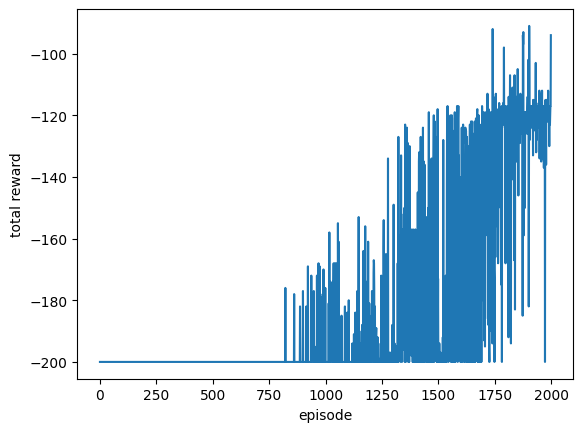

In [ ]:
# Plot the rewards wrt each training episode
showPlotReward(rewardList)

##### Testing

In [11]:
# Load the pre-trained model
model = createModel()
model.load_weights(checkpoint_third)

In [14]:
env = gym.make("MountainCar-v0", render_mode= "human")
state, _ = env.reset()
total_reward = 0
truncated = False
done = False
while not done and not truncated:
        q_values = model.predict(tf.constant([state]), verbose=0)
        action = np.argmax(q_values[0])
        new_state, reward, done, truncated, info = env.step(action)
       
        total_reward += reward
        state = new_state
        env.render()

print("Reward: {}".format(total_reward))
env.close()

Reward: -114.0
